## Exploring data visualization to look for subsetting

#### Credits
* notebook by Jessica Scheick, derived from DEM example

#### Setup
##### The Notebook was run on ICESat2 Hackweek 2019 pangeo image
##### For full functionality,
- Please install [icepyx](https://github.com/icesat2py/icepyx), [topolib](https://github.com/ICESAT-2HackWeek/topohack), [contextily](https://github.com/darribas/contextily) using `git clone xxxxx`, `pip install -e .` workflow (see below; **you must restart your kernel after installing the packages**)
- Download [NASA ASP](https://github.com/NeoGeographyToolkit/StereoPipeline) tar ball and unzip, we execute the commands from the notebook, using the path to the untared bin folder for the given commands.

In [1]:
%%bash
cd ~
# git clone https://github.com/icesat2py/icepyx.git
# git clone https://github.com/ICESAT-2HackWeek/topohack.git
# git clone https://github.com/darribas/contextily.git

cd contextily
pip install -e .
cd ../topohack
pip install -e .
cd ../icepyx
pip install -e .

Obtaining file:///home/jovyan/contextily
  Using cached https://files.pythonhosted.org/packages/53/fc/3d1b47e8e82ea12c25203929efb1b964918a77067a874b2c7631e2ec35ec/geopy-1.21.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8b/62/26ec95a98ba64299163199e95ad1b0e34ad3f4e176e221c40245f211e425/geographiclib-1.50-py3-none-any.whl
  Found existing installation: contextily 0.9.2
    Uninstalling contextily-0.9.2:
      Successfully uninstalled contextily-0.9.2
  Running setup.py develop for contextily
Obtaining file:///home/jovyan/topohack
  Running setup.py develop for topolib
Obtaining file:///home/jovyan/icepyx
  Running setup.py develop for icepyx


In [1]:
%cd ~
#needs to be wherever icepyx, contextily, and topolib are installed in the previous step (ideally $HOME)
# %pwd

/home/jovyan


#### ICESat-2 product being explored : [ATL08](https://nsidc.org/data/atl08)
- Along track heights for canopy (land and vegitation) and  terrain
- Terrain heights provided are aggregated over every 100 m along track interval, output contains "h_te_best_fit: height from best fit algorithm for all photons in the range", median height and others. Here we use h_te_best_fit.
- See this preliminary introduction and quality assessment [paper](https://www.mdpi.com/2072-4292/11/14/1721) for more detail

### Import packages, including icepyx

In [2]:
#from icepyx import is2class as ipd
import os
import shutil
import h5py
import xarray as xr
# depedencies
import getpass
#from topolib.subsetDat import subsetBBox;
from topolib import icesat2_data
import glob
import rasterio
from topolib import gda_lib
from topolib import dwnldArctic
import numpy as np
import geopandas as gpd
from multiprocessing import Pool
import contextily as ctx
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
%load_ext autoreload
from icepyx import is2class as ipd
%autoreload 2
#in order to use "as ipd", you have to use autoreload 2, which will automatically reload any module not excluded by being imported with %aimport -[module]

In [4]:
%cd ~/icepyx/dev-notebooks

/home/jovyan/icepyx/dev-notebooks


## subset and non data objects

In [6]:
region_areg = ipd.Icesat2Data('ATL08', [-73.9, 10.7, -73.4, 11.1], ['2018-12-01','2019-09-01'], \
                          start_time='00:00:00', end_time='23:59:59')
#2019-01-04; 2019-01-06 works for subsetting

In [7]:
region_asub = ipd.Icesat2Data('ATL08', [-73.9, 10.7, -73.4, 11.1], ['2018-12-01','2019-09-01'], \
                          start_time='00:00:00', end_time='23:59:59')
#2019-02-01; 2019-02-04 doesn't work for subsetting

above: bounding box in Colombia
below: shapefile in Antarctica

In [7]:
region_areg = ipd.Icesat2Data('ATL06', '/home/jovyan/icepyx/doc/examples/supporting_files/data-access_PineIsland/glims_polygons.kml',\
                           ['2019-02-22','2019-02-28'], \
                          start_time='00:00:00', end_time='23:59:59')

In [8]:
region_asub = ipd.Icesat2Data('ATL06', '/home/jovyan/icepyx/doc/examples/supporting_files/data-access_PineIsland/glims_polygons.kml',\
                           ['2019-02-22','2019-02-28'], \
                          start_time='00:00:00', end_time='23:59:59')

In [18]:
region_areg=None
region_asub=None

#### Log in to Earthdata

In [9]:
earthdata_uid = 'Jessica.scheick'
email = 'jessica.scheick@maine.edu'
sessionr=region_areg.earthdata_login(earthdata_uid, email)
sessions=region_asub.earthdata_login(earthdata_uid, email)

Earthdata Login password:  ········
Earthdata Login password:  ········


In [22]:
#search for available granules
region_areg.avail_granules()

{'Number of available granules': 22,
 'Average size of granules (MB)': 57.7880039648591,
 'Total size of all granules (MB)': 1271.3360872269}

In [23]:
region_asub.avail_granules()

{'Number of available granules': 22,
 'Average size of granules (MB)': 57.7880039648591,
 'Total size of all granules (MB)': 1271.3360872269}

In [21]:
print(region_areg.granule_info)
print(region_asub.granule_info)

{'Number of available granules': 2, 'Average size of granules (MB)': 27.7243270874, 'Total size of all granules (MB)': 55.4486541748}
{'Number of available granules': 2, 'Average size of granules (MB)': 27.7243270874, 'Total size of all granules (MB)': 55.4486541748}


#### Place the order

In [10]:
region_areg.order_granules(sessionr, subset=False)
#region_a.order_granules(session, verbose=True)

{'short_name': 'ATL06', 'version': '002', 'temporal': '2019-02-22T00:00:00Z,2019-02-28T23:59:59Z', 'polygon': '-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,-101.449791,-76.666392,-101.310795,-76.6

In [16]:
region_asub.order_granules(sessions, subset=True, verbose=True)
#region_a.order_granules(session, verbose=True)

{'short_name': 'ATL06', 'version': '002', 'temporal': '2019-02-22T00:00:00Z,2019-02-28T23:59:59Z', 'polygon': '-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,-101.449791,-76.666392,-101.310795,-76.6

#### Download the order

In [17]:
wd=%pwd
pathreg = wd + '/downloadreg'
pathsub = wd + '/downloadsub'

In [18]:
region_areg.download_granules(sessionr, pathreg)

Beginning download of zipped output...
Data request 5000000454318 of  1  order(s) is complete.


In [19]:
region_asub.download_granules(sessions, pathsub)

Beginning download of zipped output...
Data request 5000000454322 of  1  order(s) is complete.


#### Clean up the download folder by removing individual order folders:

In [22]:
#Clean up Outputs folder by removing individual granule folders 
path=pathsub
for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

## Preprocess #2
- Convert data into geopandas dataframe, which allows for doing basing geospatial opertaions

In [23]:
%cd /home/jovyan/icepyx/dev-notebooks

/home/jovyan/icepyx/dev-notebooks


In [24]:
# glob to list of files (run block of code creating wd and path variables if starting processing here)
ATL08_list = sorted(glob.glob(pathreg+'/*.h5'))
print(ATL08_list)

['/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190222031203_08500210_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190222031944_08500211_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190222155404_08580211_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190222155947_08580212_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190223024624_08650210_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190223025405_08650211_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190223152825_08730211_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190223153408_08730212_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190224022046_08800210_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadreg/ATL06_20190224022827_08800211_002_01.h5']


In [25]:
# glob to list of files (run block of code creating wd and path variables if starting processing here)
ATL08_listsub = sorted(glob.glob(pathsub+'/*.h5'))
print(ATL08_listsub)

['/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190222031203_08500210_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190222155404_08580211_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190222155947_08580212_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190223024624_08650210_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190223025405_08650211_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190223153408_08730212_002_01.h5', '/home/jovyan/icepyx/dev-notebooks/downloadsub/processed_ATL06_20190224022827_08800211_002_01.h5']


### Examine content of 1 ATLO8 hdf file

In [27]:
# dict containing data entries to retrive (ATL08)
dataset_dict = {'land_segments':['delta_time','longitude','latitude','atl06_quality_summary','quality','terrain_flg'], 'land_segments/terrain':['h_te_best_fit']}

In [38]:
#gda_lib.ATL08_to_dict(ATL08_list[0],dataset_dict)

In [31]:
## the data can be converted to geopandas dataframe, see ATL08_2_gdf function in topolib gda_lib
temp_gdf = gda_lib.ATL08_2_gdf(ATL08_list[0],dataset_dict)

UnboundLocalError: local variable 'df_final' referenced before assignment

In [29]:
## the data can be converted to geopandas dataframe, see ATL08_2_gdf function in topolib gda_lib
temp_gdfsub = gda_lib.ATL08_2_gdf(ATL08_listsub[0],dataset_dict)

UnboundLocalError: local variable 'df_final' referenced before assignment

In [14]:
temp_gdf.head()

,delta_time,longitude,latitude,terrain_flg,h_te_best_fit,pair,beam,p_b,geometry
0,3.439855e+07,-72.739960,22.674255,0.0,-43.186260,1.0,0.0,1.0_0.0,POINT (-72.73995971679688 22.67425537109375)
1,3.439855e+07,-72.740051,22.673355,0.0,-43.869007,1.0,0.0,1.0_0.0,POINT (-72.74005126953125 22.67335510253906)
2,3.439855e+07,-72.755119,22.531675,0.0,-42.931442,1.0,0.0,1.0_0.0,POINT (-72.75511932373047 22.53167533874512)
3,3.439855e+07,-72.774513,22.350164,1.0,-36.861523,1.0,0.0,1.0_0.0,POINT (-72.77451324462891 22.35016441345215)
4,3.439855e+07,-72.774612,22.349264,1.0,-36.810665,1.0,0.0,1.0_0.0,POINT (-72.77461242675781 22.34926414489746)


In [32]:
%matplotlib inline

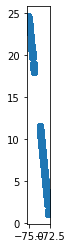

In [41]:
temp_gdf.plot()
#plt.ylim(10.5,11.2)

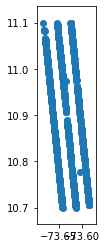

In [46]:
temp_gdfsub.plot()
#plt.ylim(10.5,11.2)

In [42]:
temp_gdf.total_bounds

array([-75.08763123,   1.08277035, -72.62879181,  24.57600975])

In [43]:
region_areg.spatial_extent

['bounding box', [-73.9, 10.7, -73.4, 11.1]]

In [47]:
temp_gdfsub.total_bounds

array([-73.68257904,  10.70025349, -73.58360291,  11.09985828])

In [30]:
colombia_crs = {'init':'epsg:32618'}
plot_web = {'init':'epsg:3857'}

In [15]:
temp_gdf.keys()

Index(['delta_time', 'longitude', 'latitude', 'terrain_flg', 'h_te_best_fit',
       'pair', 'beam', 'p_b', 'geometry'],
      dtype='object')

In [28]:
gdf_list = [(gda_lib.ATL08_2_gdf(x,dataset_dict)) for x in ATL08_list]
gdf_colombia = gda_lib.concat_gdf(gdf_list)

In [29]:
gdf_listsub = [(gda_lib.ATL08_2_gdf(x,dataset_dict)) for x in ATL08_listsub]
gdf_colombiasub = gda_lib.concat_gdf(gdf_listsub)

# Plot Bounding box data (Colombia)
- Visualise data footprints

[]

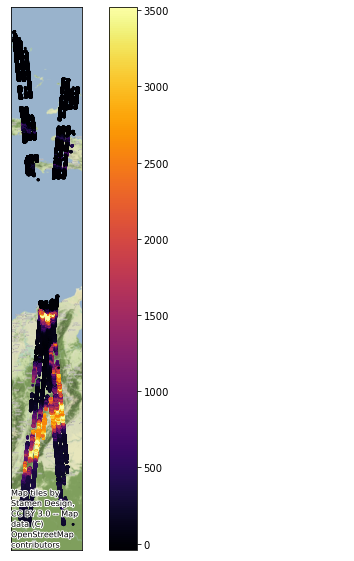

In [31]:
fig,ax = plt.subplots(figsize=(10,10))
temp_web = gdf_colombia.to_crs(plot_web)
clim = np.percentile(temp_web['h_te_best_fit'].values,(2,98))
temp_web.plot('h_te_best_fit',ax=ax,s=3,legend=True,cmap='inferno',vmin=clim[0],vmax=clim[1])
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

[]

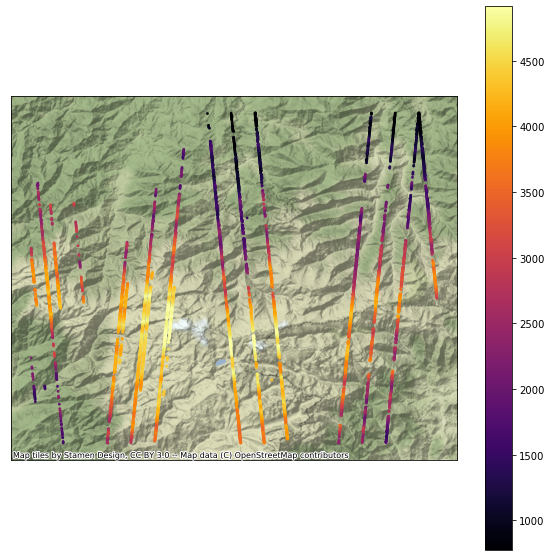

In [33]:
fig,ax = plt.subplots(figsize=(10,10))
temp_websub = gdf_colombiasub.to_crs(plot_web)
climsub = np.percentile(temp_websub['h_te_best_fit'].values,(2,98))
temp_websub.plot('h_te_best_fit',ax=ax,s=3,legend=True,cmap='inferno',vmin=climsub[0],vmax=climsub[1])
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

# Plot Polygon data (Antarctica)
- Visualise data footprints

### Convert the list of hdf5 files into more familiar Pandas Dataframe

In [34]:
# dict containing data entries to retrive (ATL06)
dataset_dict={'land_ice_segments':['atl06_quality_summary','delta_time','h_li','hli_sigma',\
           'latitude','longitude','segment_id','sigma_geo_h'], 'land_ice_segments/ground_track':['x_atc']}

In [38]:
ant_crs = {'init':'epsg:3031'}
plot_web = {'init':'epsg:3857'}

In [35]:
gdf_list = [(gda_lib.ATL06_2_gdf(x,dataset_dict)) for x in ATL08_list]
gdf_colombia = gda_lib.concat_gdf(gdf_list)

In [36]:
gdf_listsub = [(gda_lib.ATL06_2_gdf(x,dataset_dict)) for x in ATL08_listsub]
gdf_colombiasub = gda_lib.concat_gdf(gdf_listsub)

[]

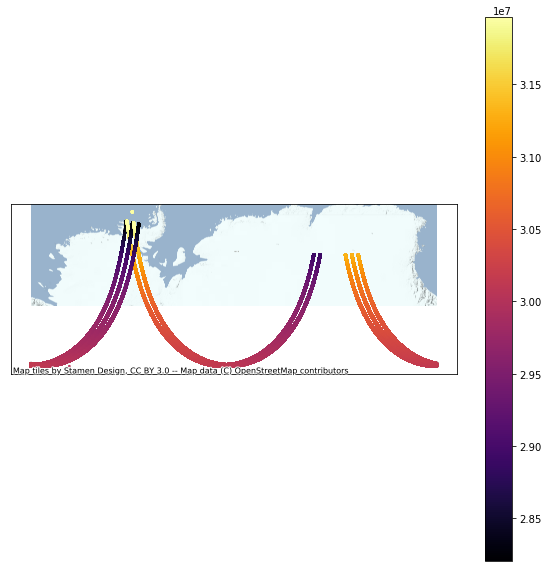

In [39]:
fig,ax = plt.subplots(figsize=(10,10))
temp_web = gdf_colombia.to_crs(plot_web)
clim = np.percentile(temp_web['x_atc'].values,(2,98))
temp_web.plot('x_atc',ax=ax,s=3,legend=True,cmap='inferno',vmin=clim[0],vmax=clim[1])
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

[]

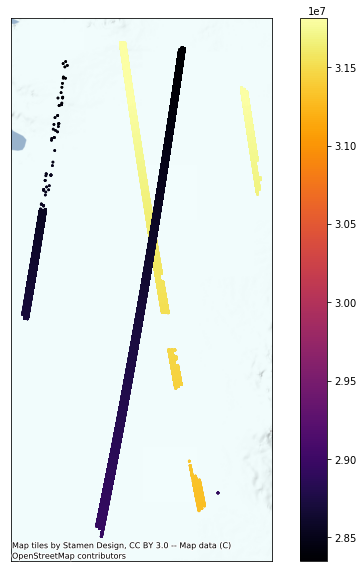

In [40]:
fig,ax = plt.subplots(figsize=(10,10))
temp_websub = gdf_colombiasub.to_crs(plot_web)
climsub = np.percentile(temp_websub['x_atc'].values,(2,98))
temp_websub.plot('x_atc',ax=ax,s=3,legend=True,cmap='inferno',vmin=climsub[0],vmax=climsub[1])
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])